In [3]:
import numpy as np
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale

%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

In [4]:
ds_h = pd.read_csv('./Downloads/week4day1/체질검사.csv',encoding='CP949',engine='python')
ds_h.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [6]:
ds_h_y=ds_h["FAT"]
ds_h_x=ds_h.drop("FAT", axis=1, inplace=False)
print("목표변수 데이터 크기:{}".format(ds_h_y.shape))
print("설명변수 데이터 크기:{}".format(ds_h_x.shape))
#관측치 252개, 설명변수 13개, 목표변수 FAT 

목표변수 데이터 크기:(252,)
설명변수 데이터 크기:(252, 13)


In [7]:
ds_h_x_const=sm.add_constant(ds_h_x)
ds_h_x_const.head()
#회귀분석을 위한 절편 생성

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1.0,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,1.0,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,1.0,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,1.0,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,1.0,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


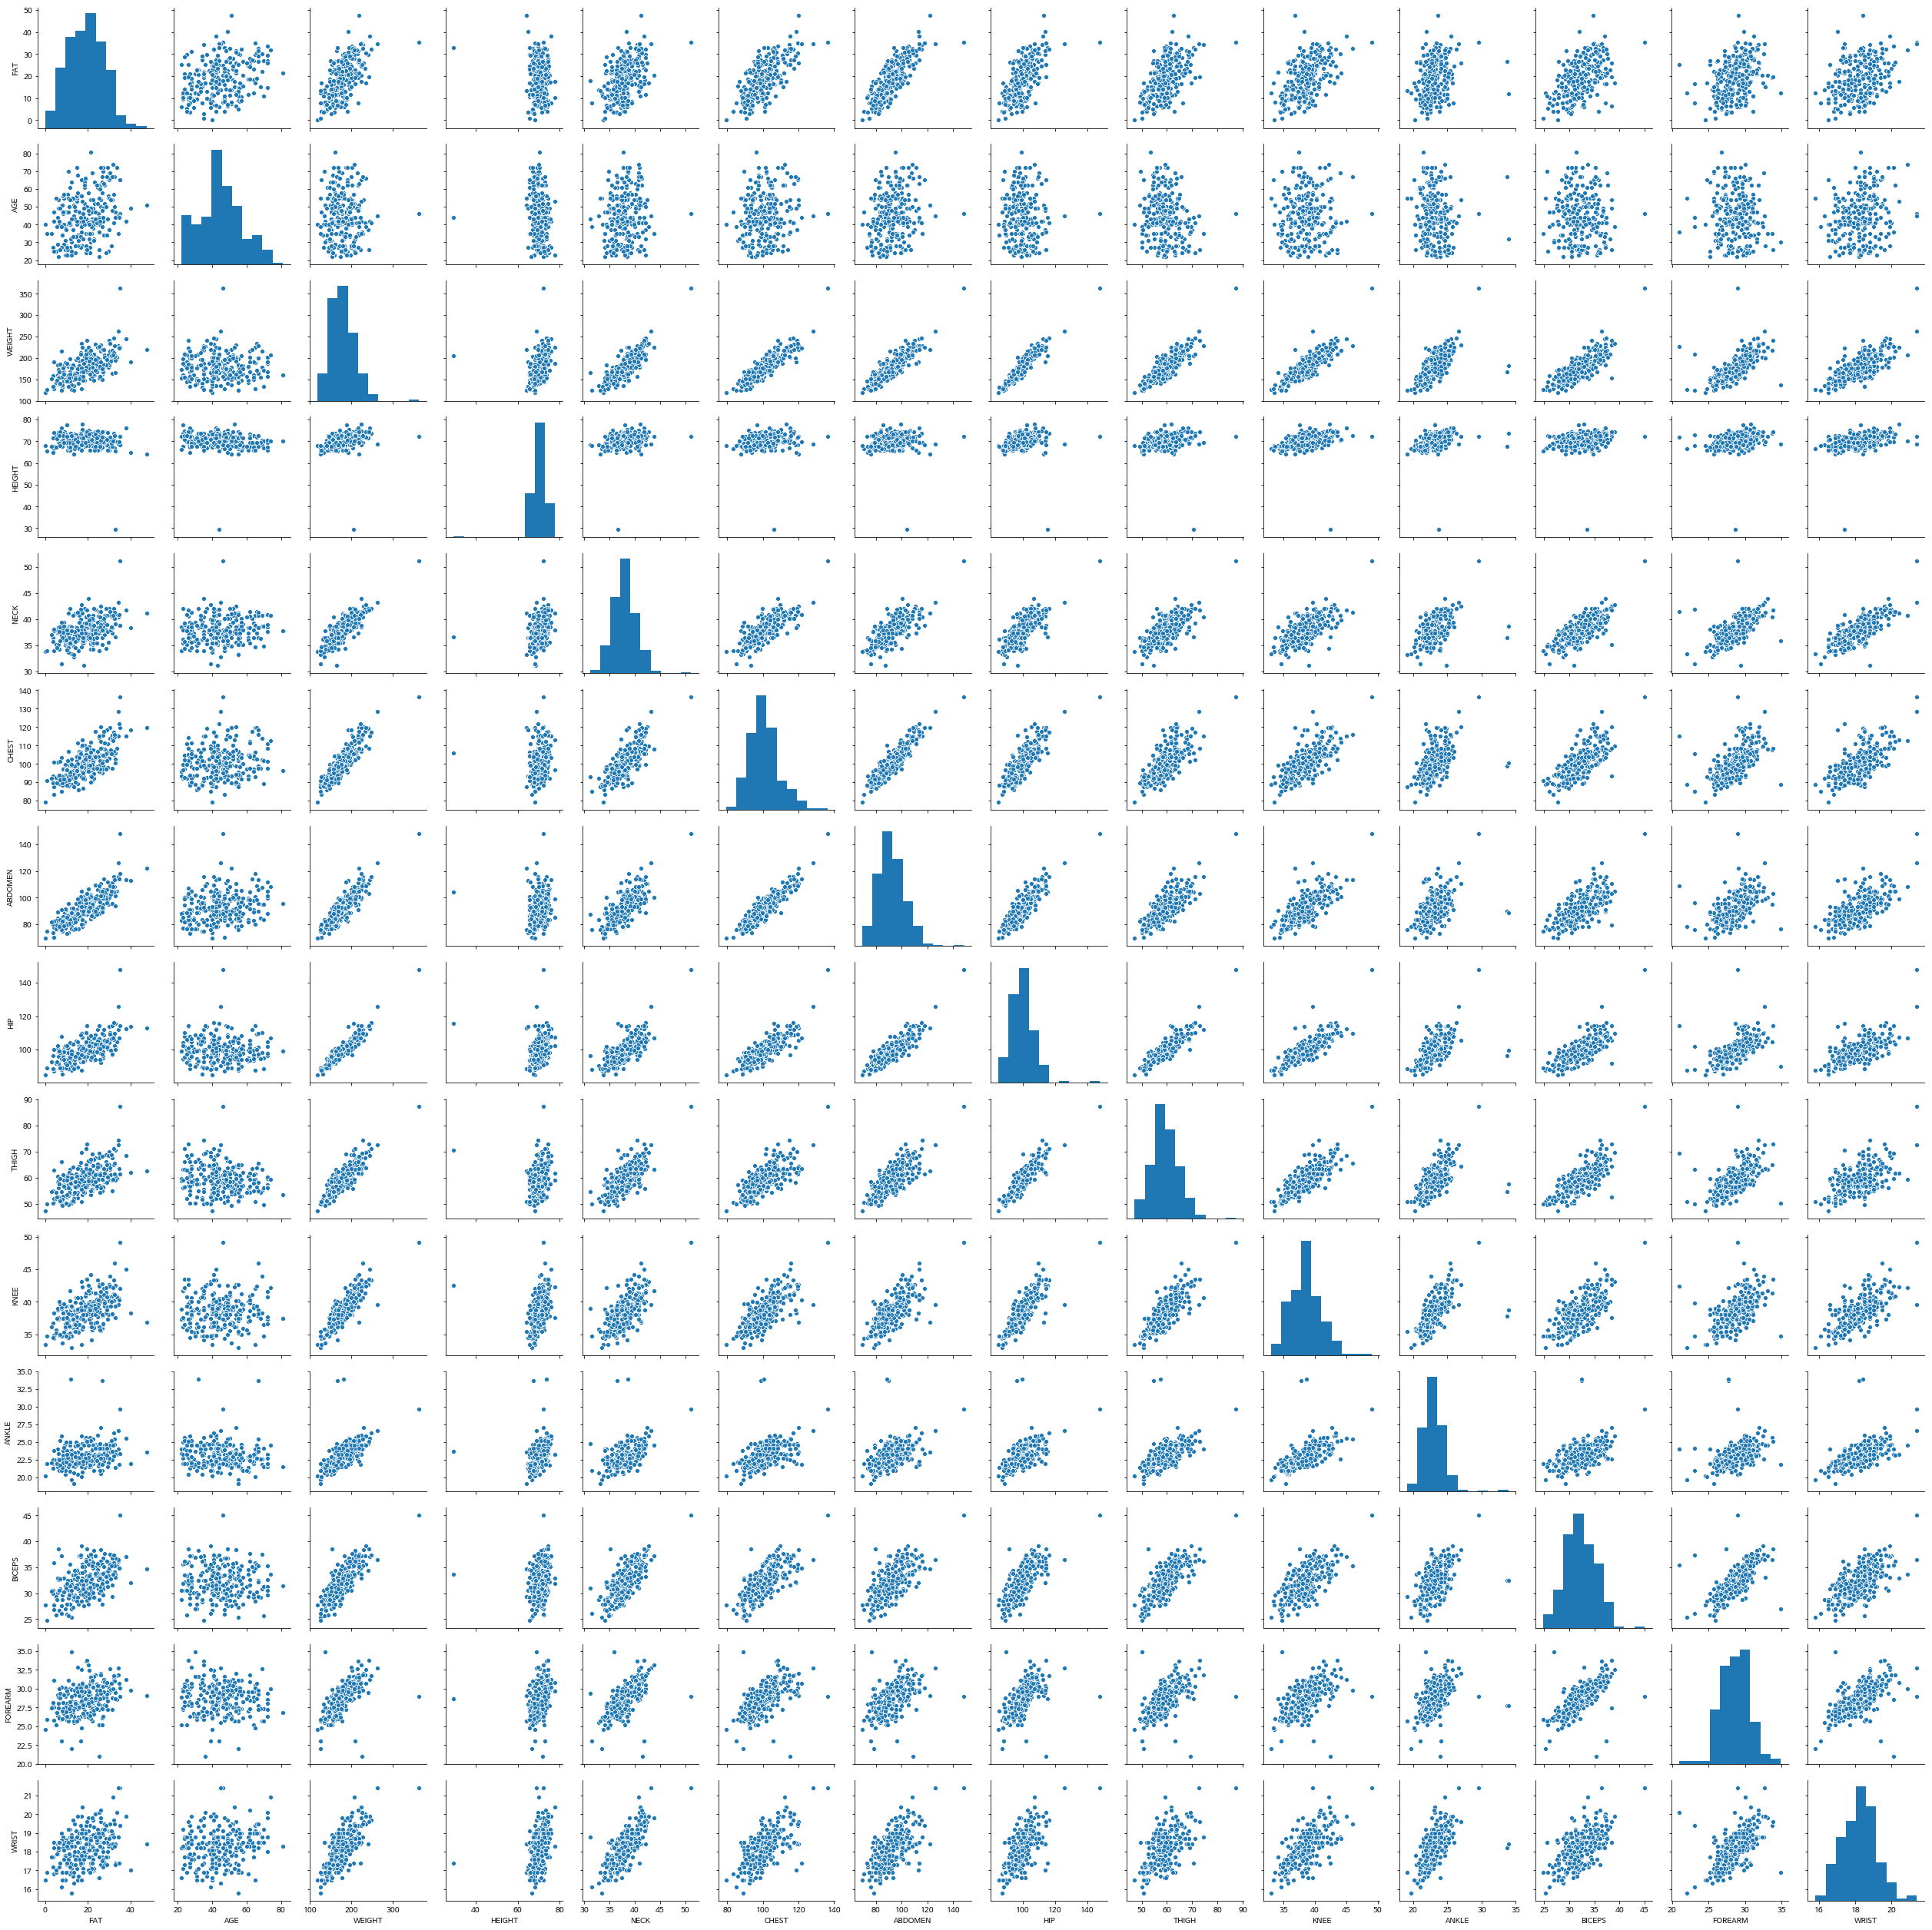

In [8]:
sns.pairplot(ds_h)
#2,4,5,6,7,8,9,11번째 변수의 양의 상관관계 확인
#그러나 변수끼리 다중공선성이 매우 강하게 의심
#3번째 변수는 특정 구간대에서만 데이터가 분포하며 왼쪽의 이상치 확인 필요
#그 외에도 곳곳에 이상치로 의심되는 data들이 보이며 확인 필요

In [9]:
ds_h.corr().round(3)
#목표변수 FAT에 가장 큰 영향을 주는 요소는 ABDOMEN으로 추측되나, 다중공선성 관계가 의심되는 변수가 많음
#CHEST, HIP, WEIGHT와도 상관관계가 유의미해 보임
#HEIGHT와는 매우 약한 음의 상관관계를 보임

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665


In [10]:
reg_multi_model=sm.OLS(ds_h_y,ds_h_x_const)
reg_multi_results=reg_multi_model.fit()
print(reg_multi_results.summary())
#252개의 관측치, 변수(상수항포함)는 14개, 모델의 자유도는 13
#p값이 0.05보다 작으므로 회귀모델로 유의
#설명계수가 0.749로 높은 편
#그러나 설명변수들의 p값이 상당 수 매우 높아 회귀계수로서 유의하지 않음
#이에 따라 적절한 변수 제거나 선택이 필요

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Thu, 31 Jan 2019   Prob (F-statistic):           7.72e-64
Time:                        12:08:41   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.1885     17.349     -1.048      0.2

In [11]:
ds_vif=pd.DataFrame()
ds_vif["variable"]=ds_h_x_const.columns
ds_vif["VIF"]=[variance_inflation_factor(ds_h_x_const.values,i) for i in range(ds_h_x_const.shape[1])]
ds_vif.sort_values("VIF",inplace=True)
ds_vif.round(3)
#전체 설명변수를 대상으로 다중공선성 검토
#2,6,7번째 변수들의 VIF가 10 이상이므로 다중공선성을 고려해야함
#WEIGHT를 빼도 큰 영향이 없으면 모델에서 제외

,variable,VIF
3,HEIGHT,1.675
10,ANKLE,1.908
12,FOREARM,2.192
1,AGE,2.250
13,WRIST,3.378
11,BICEPS,3.620
4,NECK,4.324
9,KNEE,4.612
8,THIGH,7.778
5,CHEST,9.461


In [12]:
model=LinearRegression()
rfe=RFE(estimator=model, n_features_to_select=5).fit(ds_h_x,ds_h_y)
selected_cols=ds_h_x.columns[rfe.support_]
removed_cols=ds_h_x.columns[~rfe.support_]
print("Selected Variables:{}".format(selected_cols))
print("Removed Variables:{}".format(removed_cols))
#후진제거법에 의해 선택 변수/제거 변수 확인
#5개까지만 변수를 선택하므로 가장 영향력이 큰 5개의 변수만 남김
#모든 변수를 다 넣은 상태에서 영향력이 상대적으로 적은 변수들을 제거


Selected Variables:Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables:Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


In [15]:
ds_h_x_rfe=sm.add_constant(ds_h_x_const[selected_cols])
reg_multi_rfe_model=sm.OLS(ds_h_y,ds_h_x_rfe)
reg_multi_rfe_results=reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())
#관측치 252개, 변수6개(상수항포함), 모델의 자유도는 5
#F(ANOVA)의 p값이 0.05보다 작으므로 회귀모델로 유의
#기존 모든 선택변수로 돌린 모델보다 설명계수는 0.749에서 0.731로 소폭 감소
#그러나 선택된 5개의 변수들의 p값이 모두 0.05이하이므로 유의하고 이를 사용해 회귀식 도출 가능
#모든 설명변수들이 유의

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Thu, 31 Jan 2019   Prob (F-statistic):           4.38e-68
Time:                        12:08:52   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7037      6.231      0.434      0.6

In [16]:
ds_rfe_vif=pd.DataFrame()
ds_rfe_vif["variable"]=ds_h_x_rfe.columns
ds_rfe_vif["VIF"]=[variance_inflation_factor(ds_h_x_rfe.values,i) for i in range(ds_h_x_rfe.shape[1])]
ds_rfe_vif.sort_values("VIF",inplace=True)
ds_rfe_vif.round(3)
#다중공선성을 검토한 결과 모든 설명변수(5개)가 VIF가 10을 넘지 않음
#따라서 다중공선성을 특별히 검토하지 않음

,variable,VIF
4,FOREARM,1.769
5,WRIST,2.430
1,NECK,3.565
3,HIP,4.662
2,ABDOMEN,4.818
0,const,509.235


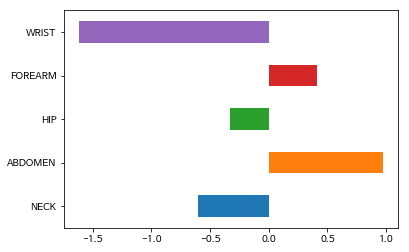

In [17]:
ds_reg_coef=pd.DataFrame({"Coef":reg_multi_rfe_results.params.values[1:]}, index=reg_multi_rfe_model.exog_names[1:])
ds_reg_coef.plot.barh(y="Coef", legend=False)
#표준화 적용 이전의 설명변수 중요도
#단순 계수 분석으로 WRIST가 높은 것으로 나타남
#WRIST가 작을수록 FAT이 큰 결과, 현실적으로 비합리적 설명
#scale을 고려하지 않아 이에 따른 처리 필요

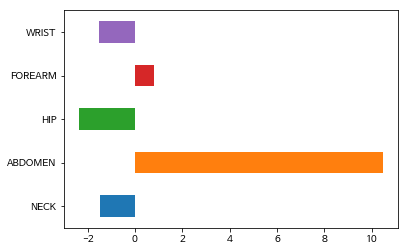

In [18]:
ds_h_x_scaled=scale(ds_h_x_const[selected_cols])
ds_h_x_scaled=sm.add_constant(ds_h_x_scaled)
reg_multi_scaled_model=sm.OLS(ds_h_y,ds_h_x_scaled)
reg_multi_scaled_results=reg_multi_scaled_model.fit()
ds_reg_scaled_coef=pd.DataFrame({"Coef":reg_multi_scaled_results.params.values[1:]},
                               index=reg_multi_rfe_model.exog_names[1:])
ds_reg_scaled_coef.plot.barh(y="Coef",legend=False)
#scale로 데이터 표준화(평균=0, 표준편차=1) 시킴
#회귀계수의 방향은 유지하나 크기가 변함
#표준화 이전과 비교해 ABDOMEN이 가장 중요한 변수이고 실제로도 가장 중요한 변수
#가장 영향력이 작아보이던 HIP이 두 번째로 중요


In [24]:
import statsmodels.formula.api as smf
formula_model=smf.ols(formula="FAT ~ THIGH",data=ds_h)
formula_result=formula_model.fit()
print(formula_result.summary())
#4개의 변수들로만 OLS
#p값은 0.05보다 작아 유의
#설명력은 0.714로 낮지 않은 편
#FOREARM이 0.102로 0.05보다 높아서 회귀계수가 유의하지 않음
#따라서 FOREARM에 대한 처리 필요

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     114.0
Date:                Thu, 31 Jan 2019   Prob (F-statistic):           3.61e-22
Time:                        12:10:48   Log-Likelihood:                -845.11
No. Observations:                 252   AIC:                             1694.
Df Residuals:                     250   BIC:                             1701.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -33.8422      4.983     -6.792      0.0

In [ ]:
ds_h_r=ds_h.drop(["FAT", "WEIGHT",], axis=1, inplace=False)
ds_h_r.head()

In [43]:
formula_model=smf.ols(formula="FAT ~ NECK + ABDOMEN + FOREARM + WRIST",data=ds_h)
formula_result=formula_model.fit()
print(formula_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     154.1
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           6.80e-66
Time:                        14:52:16   Log-Likelihood:                -734.77
No. Observations:                 252   AIC:                             1480.
Df Residuals:                     247   BIC:                             1497.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.4679      5.959     -1.085      0.2

In [53]:
ds_d = pd.read_csv('./Downloads/week4day1/DIABETES.csv',encoding='CP949',engine='python')
ds_d.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [55]:
ds_d_y=ds_d["Y"]
ds_d_x=ds_d.drop("Y", axis=1, inplace=False)
print("목표변수 데이터 크기:{}".format(ds_d_y.shape))
print("설명변수 데이터 크기:{}".format(ds_d_x.shape))
#관측치 442개, 설명변수 10개, 목표변수 Y

목표변수 데이터 크기:(442,)
설명변수 데이터 크기:(442, 10)


In [56]:
ds_d_x_const=sm.add_constant(ds_d_x)
ds_d_x_const.head()
#회귀분석을 위한 절편 생성

,const,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,1.0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,1.0,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,1.0,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,1.0,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,1.0,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


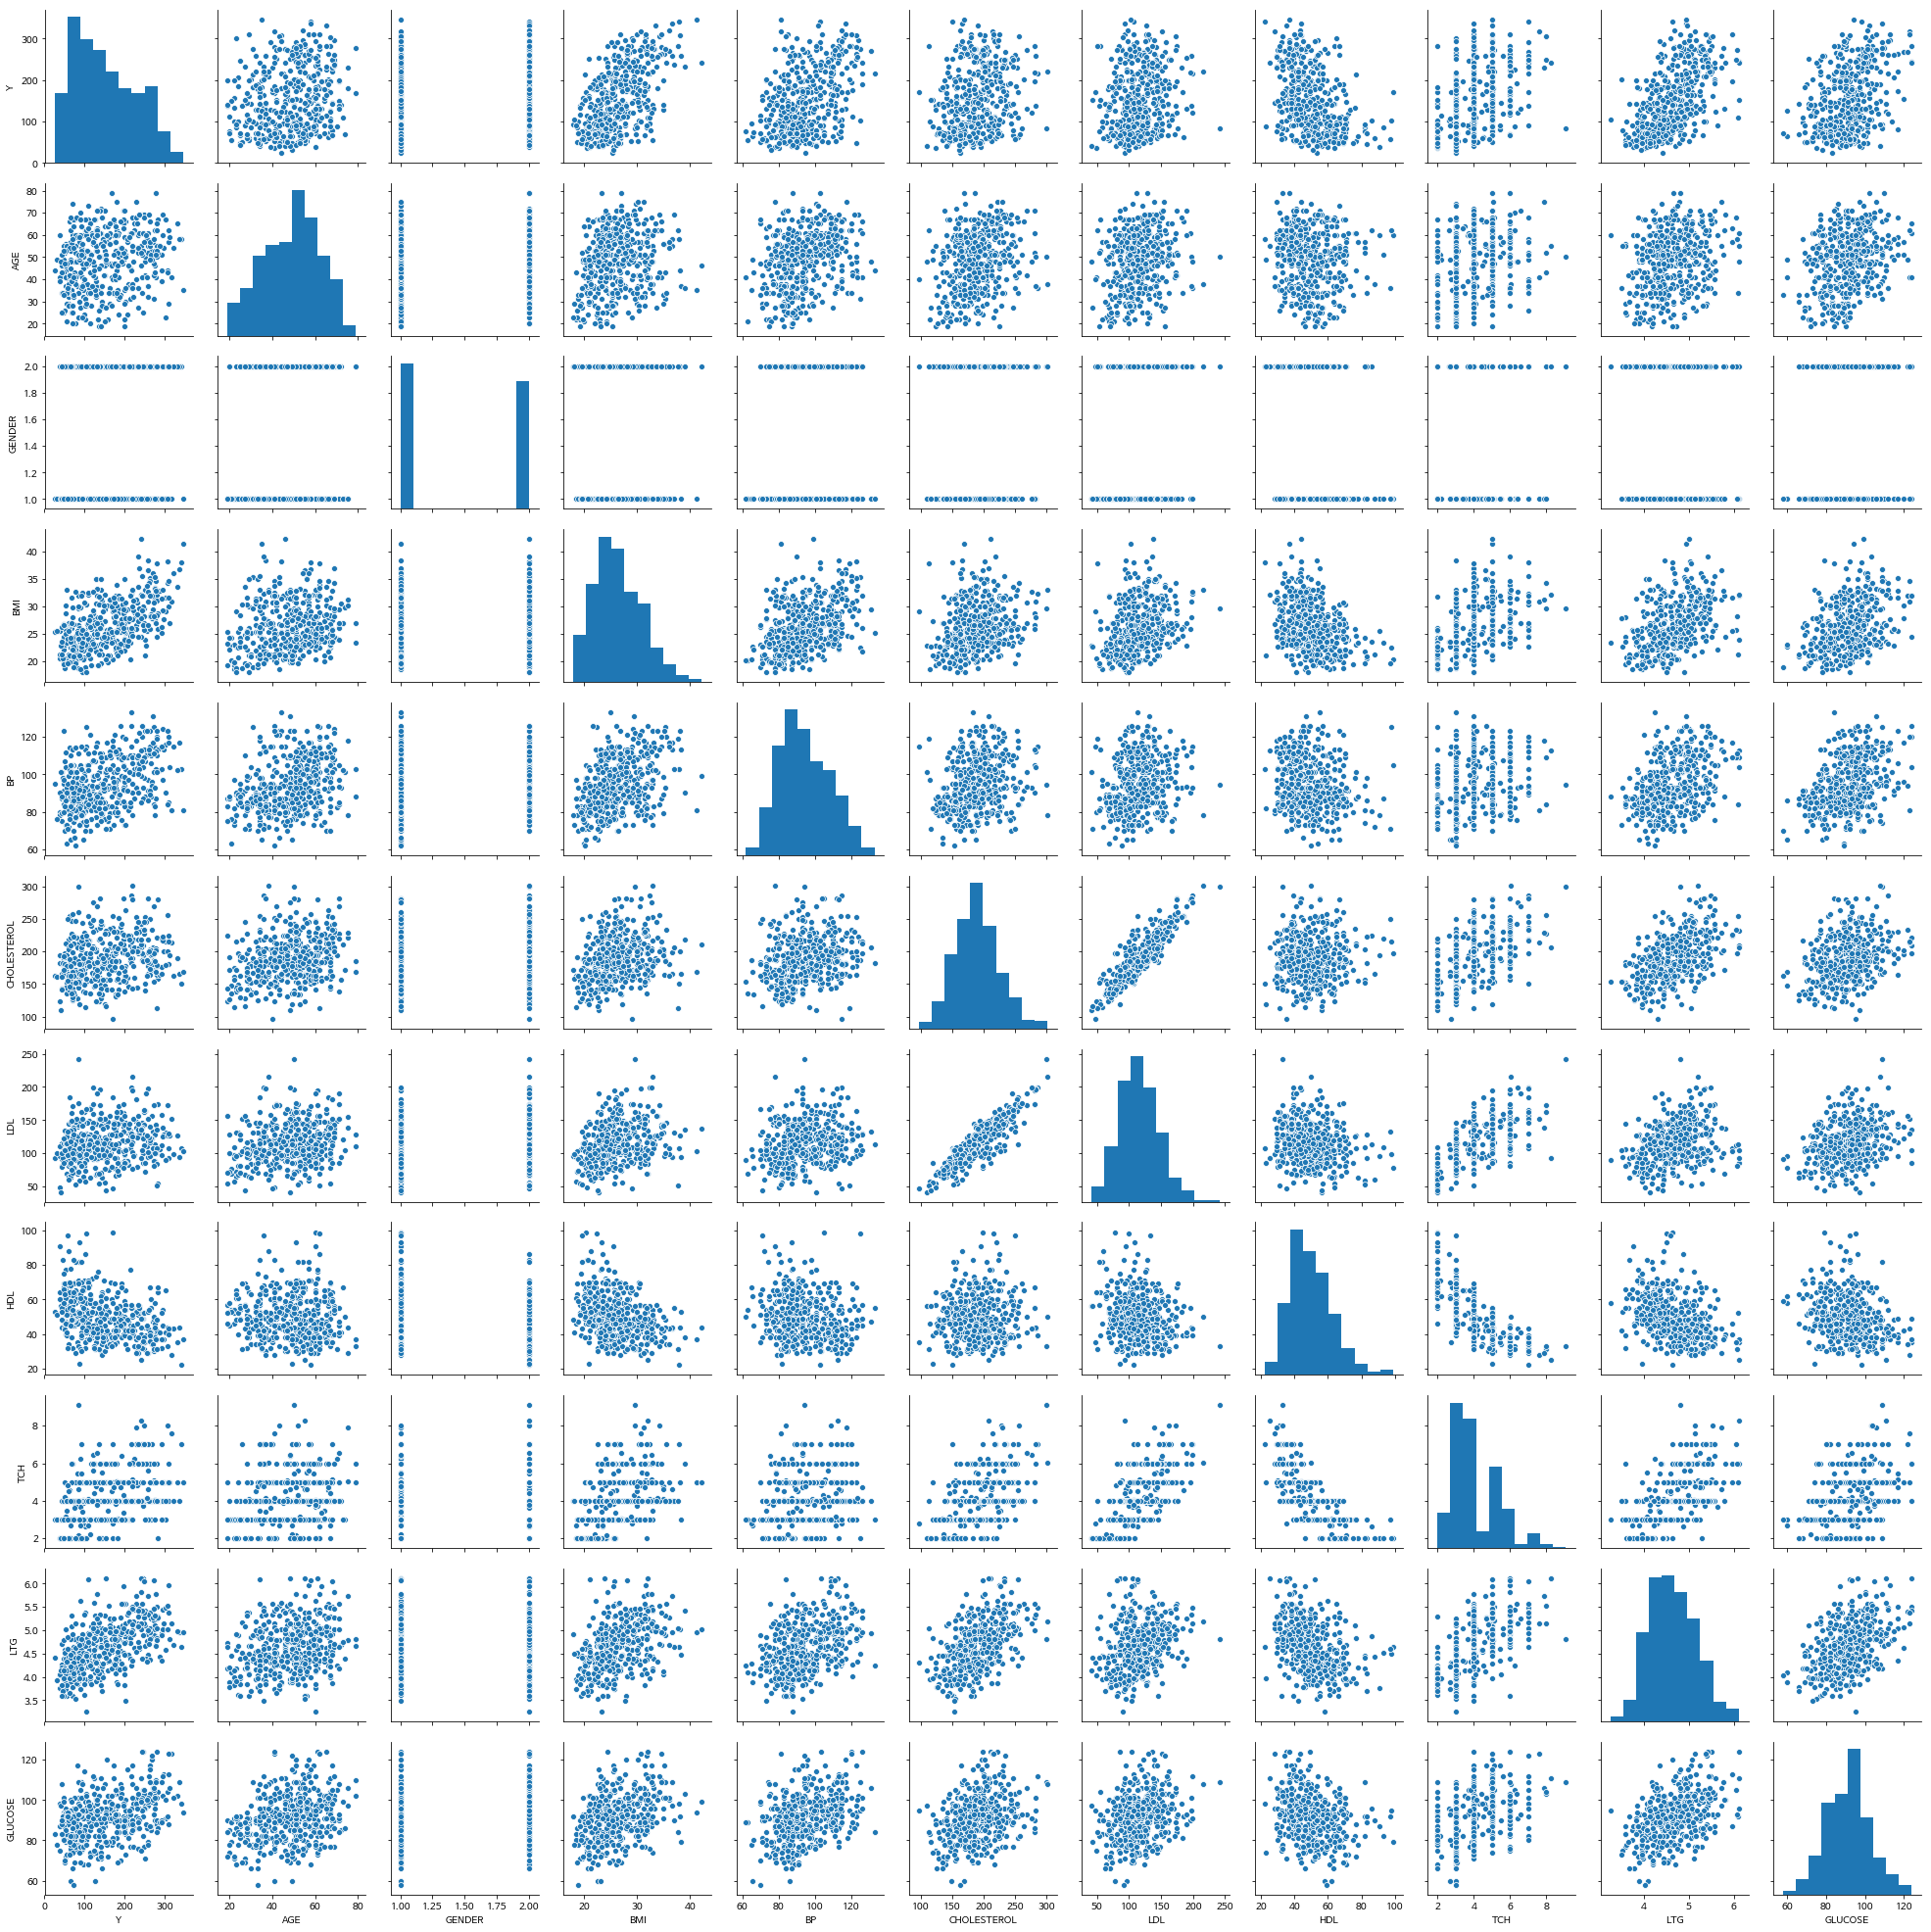

In [60]:
sns.pairplot(ds_d)

In [59]:
ds_d.corr().round(3)
#Y와 HDL은 음의 상관관계
#Y와 BMI, LTG가 어느 정도 양의 상관관계를 보임
#CHOLESTEROL과 LDL은 높은 양의 상관관계를 보이므로 다중공선성 주의
#

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
Y,1.000,0.188,0.043,0.586,0.441,0.212,0.174,-0.395,0.430,0.566,0.382
AGE,0.188,1.000,0.174,0.185,0.335,0.260,0.219,-0.075,0.204,0.271,0.302
GENDER,0.043,0.174,1.000,0.088,0.241,0.035,0.143,-0.379,0.332,0.150,0.208
BMI,0.586,0.185,0.088,1.000,0.395,0.250,0.261,-0.367,0.414,0.446,0.389
BP,0.441,0.335,0.241,0.395,1.000,0.242,0.186,-0.179,0.258,0.393,0.390
CHOLESTEROL,0.212,0.260,0.035,0.250,0.242,1.000,0.897,0.052,0.542,0.516,0.326
LDL,0.174,0.219,0.143,0.261,0.186,0.897,1.000,-0.196,0.660,0.318,0.291
HDL,-0.395,-0.075,-0.379,-0.367,-0.179,0.052,-0.196,1.000,-0.738,-0.399,-0.274
TCH,0.430,0.204,0.332,0.414,0.258,0.542,0.660,-0.738,1.000,0.618,0.417
LTG,0.566,0.271,0.150,0.446,0.393,0.516,0.318,-0.399,0.618,1.000,0.465


In [107]:
reg_multid_model=sm.OLS(ds_d_y,ds_d_x)
reg_multid_results=reg_multid_model.fit()
print(reg_multid_results.summary())
#442개의 관측치, 11개(상수항포함)의 변수, 모델의 자유도 10
#모델의 설명력 51.8%, p값은 0.05보다 낮음
#AGE, HDL 회귀계수의 p값이 높음
#적절한 변수 제거 및 선택 필요

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     372.3
Date:                Wed, 30 Jan 2019   Prob (F-statistic):          2.76e-205
Time:                        15:50:56   Log-Likelihood:                -2398.3
No. Observations:                 442   AIC:                             4817.
Df Residuals:                     432   BIC:                             4857.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
AGE             0.0223      0.223      0.100      

In [110]:
ds_vifd=pd.DataFrame()
ds_vifd["variable"]=ds_d_x.columns
ds_vifd["VIF"]=[variance_inflation_factor(ds_d_x.values,i) for i in range(ds_d_x.shape[1])]
ds_vifd.sort_values("VIF",inplace=True)
ds_vifd.round(3)
#전체 설명변수의 다중공선성 검토
#CHOLESTEROL, LDL, HDL, LTG가 VIF가 높음
#해당 변수들이 모델에 큰 영향이 없으면 제외 고려

,variable,VIF
1,GENDER,12.192
0,AGE,17.877
6,HDL,52.293
2,BMI,55.155
3,BP,69.404
7,TCH,81.350
9,GLUCOSE,93.977
5,LDL,244.913
8,LTG,277.183
4,CHOLESTEROL,576.886


In [120]:
modeld=LinearRegression()
rfed=RFE(estimator=modeld, n_features_to_select=5).fit(ds_d_x,ds_d_y)
selected_colsd=ds_d_x.columns[rfed.support]
removed_colsd=ds_d_x.columns[~rfed.support]
print("Selected Variables:{}".format(selected_colsd))
print("Removed Variables:{}".format(removed_colsd))
#후진제거법에 의해 선택 변수/제거 변수 확인
#5개까지만 변수를 선택하므로 가장 영향력이 큰 5개의 변수만 남김
#모든 변수를 다 넣은 상태에서 영향력이 상대적으로 적은 변수들을 제거


AttributeError: 'RFE' object has no attribute 'support'

In [118]:
ds_d_x_rfe=ds_d_x[selected_colsd]
reg_multi_rfed_model=sm.OLS(ds_d_y,ds_d_x_rfe)
reg_multi_rfed_results=reg_multi_rfed_model.fit()
print(reg_multi_rfed_results.summary())
#관측치 442개, 변수6개(상수항포함), 모델의 자유도는 5
#F(ANOVA)의 p값이 0.05보다 작으므로 회귀모델로 유의
#기존 모든 선택변수로 돌린 모델보다 설명계수는 0.507에서 0.485로 소폭 감소
#TCH의 p값이 0.058로 0.05에 근사하지만, 그 외의 모든 설명변수들이 유의

,GENDER,BMI,BP,TCH,LTG
0,2,32.1,101.00,4.00,4.8598
1,1,21.6,87.00,3.00,3.8918
2,2,30.5,93.00,4.00,4.6728
3,1,25.3,84.00,5.00,4.8903
4,1,23.0,101.00,4.00,4.2905
5,1,22.6,89.00,2.00,4.1897
6,2,22.0,90.00,3.00,3.9512
7,2,26.2,114.00,4.55,4.2485
8,2,32.1,83.00,4.00,4.4773
9,1,30.0,85.00,4.00,5.3845


In [117]:
ds_rfe_vifd=pd.DataFrame()
ds_rfe_vifd["variable"]=ds_d_x_rfe.columns
ds_rfe_vifd["VIF"]=[variance_inflation_factor(ds_d_x_rfe.values,i) for i in range(ds_d_x_rfe.shape[1])]
ds_rfe_vifd.sort_values("VIF",inplace=True)
ds_rfe_vifd.round(3)
#다중공선성이 모두 2 이하로 매우 낮음

,variable,VIF
1,GENDER,1.191
3,BP,1.342
2,BMI,1.414
5,LTG,1.875
4,TCH,1.881
0,const,111.223


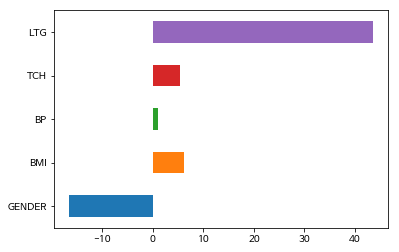

In [73]:
ds_regd_coef=pd.DataFrame({"Coef":reg_multi_rfed_results.params.values[1:]}, index=reg_multi_rfed_model.exog_names[1:])
ds_regd_coef.plot.barh(y="Coef", legend=False)
#표준화 적용 이전의 설명변수 중요도
#단순 계수 분석으로 LTG, GENDER가 높은 것으로 나타남
#LTG가 클수록, GENDER 1에 가까울수록(낮을수록, 남자?일수록)  Y가 큰 결과
#scale을 고려하지 않아 이에 따른 처리 필요

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


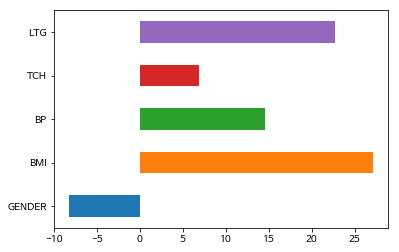

In [75]:
ds_d_x_scaled=scale(ds_d_x_const[selected_colsd])
ds_d_x_scaled=sm.add_constant(ds_d_x_scaled)
reg_multid_scaled_model=sm.OLS(ds_d_y,ds_d_x_scaled)
reg_multid_scaled_results=reg_multid_scaled_model.fit()
ds_regd_scaled_coef=pd.DataFrame({"Coef":reg_multid_scaled_results.params.values[1:]},
                               index=reg_multi_rfed_model.exog_names[1:])
ds_regd_scaled_coef.plot.barh(y="Coef",legend=False)
#scale로 데이터 표준화(평균=0, 표준편차=1) 시킴
#회귀계수의 방향은 유지하나 크기가 변함
#표준화 이전과 비교해 BMI가 가장 중요한 변수이고 실제로도 가장 중요한 변수
#가장 영향력이 작아보이던 BP가 3번째로 중요

In [5]:
import statsmodels.formula.api as smf
formula_model=smf.ols(formula="FAT ~ TIGH",data=ds_h)
formula_result=formula_model.fit()
print(formula_result.summary())

PatsyError: Error evaluating factor: NameError: name 'TIGH' is not defined
    FAT ~ TIGH
          ^^^^

In [76]:
ds_d0 = pd.read_csv('./Downloads/week4day1/DIABETES_2to0.csv',encoding='CP949',engine='python')
ds_d0.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,0,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,0,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [86]:
ds_d0_y=ds_d0["Y"]
ds_d0_x=ds_d0.drop("Y", axis=1, inplace=False)
print("목표변수 데이터 크기:{}".format(ds_h_y.shape))
print("설명변수 데이터 크기:{}".format(ds_h_x.shape))

목표변수 데이터 크기:(252,)
설명변수 데이터 크기:(252, 13)


In [87]:
ds_d0_x_const=sm.add_constant(ds_d0_x)
ds_d0_x_const.head()

,const,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,1.0,59,0,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,1.0,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,1.0,72,0,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,1.0,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,1.0,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [88]:
modeld0=LinearRegression()
rfed0=RFE(estimator=modeld0, n_features_to_select=5).fit(ds_d0_x,ds_d0_y)
selected_colsd0=ds_d0_x.columns[rfed0.support_]
removed_colsd0=ds_d0_x.columns[~rfed0.support_]
print("Selected Variables:{}".format(selected_colsd0))
print("Removed Variables:{}".format(removed_colsd0))

Selected Variables:Index(['GENDER', 'BMI', 'BP', 'TCH', 'LTG'], dtype='object')
Removed Variables:Index(['AGE', 'CHOLESTEROL', 'LDL', 'HDL', 'GLUCOSE'], dtype='object')


In [89]:
ds_d0_x_rfe=sm.add_constant(ds_d0_x_const[selected_colsd0])
reg_multi_rfed0_model=sm.OLS(ds_d0_y,ds_d0_x_rfe)
reg_multi_rfed0_results=reg_multi_rfed0_model.fit()
print(reg_multi_rfed0_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     84.11
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           9.85e-62
Time:                        15:34:51   Log-Likelihood:                -2397.9
No. Observations:                 442   AIC:                             4808.
Df Residuals:                     436   BIC:                             4832.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -342.5136     27.773    -12.333      0.0

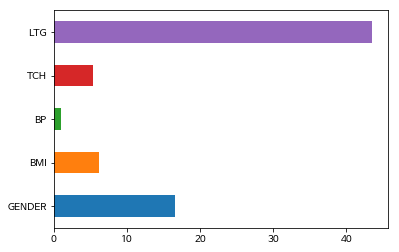

In [90]:
ds_regd0_coef=pd.DataFrame({"Coef":reg_multi_rfed0_results.params.values[1:]}, index=reg_multi_rfed0_model.exog_names[1:])
ds_regd0_coef.plot.barh(y="Coef", legend=False)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


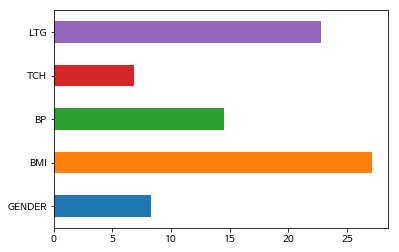

In [91]:
ds_d0_x_scaled=scale(ds_d0_x_const[selected_colsd0])
ds_d0_x_scaled=sm.add_constant(ds_d0_x_scaled)
reg_multid0_scaled_model=sm.OLS(ds_d0_y,ds_d0_x_scaled)
reg_multid0_scaled_results=reg_multid0_scaled_model.fit()
ds_regd0_scaled_coef=pd.DataFrame({"Coef":reg_multid0_scaled_results.params.values[1:]},
                               index=reg_multi_rfed0_model.exog_names[1:])
ds_regd0_scaled_coef.plot.barh(y="Coef",legend=False)

In [99]:
reg_multid_model=sm.OLS(ds_d_y,ds_d_x)
reg_multid_results=reg_multid_model.fit()
print(reg_multid_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     372.3
Date:                Wed, 30 Jan 2019   Prob (F-statistic):          2.76e-205
Time:                        15:44:22   Log-Likelihood:                -2398.3
No. Observations:                 442   AIC:                             4817.
Df Residuals:                     432   BIC:                             4857.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
AGE             0.0223      0.223      0.100      

In [105]:
modeld_=LinearRegression()
rfed_=RFE(estimator=modeld, n_features_to_select=5).fit(ds_d_x,ds_d_y)
selected_colsd_=ds_d_x.columns[rfed_.support_]
removed_colsd_=ds_d_x.columns[~rfed_.support_]
print("Selected Variables:{}".format(selected_colsd_))
print("Removed Variables:{}".format(removed_colsd_))

Selected Variables:Index(['GENDER', 'BMI', 'BP', 'TCH', 'LTG'], dtype='object')
Removed Variables:Index(['AGE', 'CHOLESTEROL', 'LDL', 'HDL', 'GLUCOSE'], dtype='object')


In [106]:
ds_d_x_rfe_=sm.add_constant(ds_d_x[selected_colsd_])
reg_multi_rfed_model_=sm.OLS(ds_d_y,ds_d_x_rfe_)
reg_multi_rfed_results_=reg_multi_rfed_model_.fit()
print(reg_multi_rfed_results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     84.11
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           9.85e-62
Time:                        15:48:55   Log-Likelihood:                -2397.9
No. Observations:                 442   AIC:                             4808.
Df Residuals:                     436   BIC:                             4832.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -309.3713     27.749    -11.149      0.0